In [47]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import requests
import pandas as pd
import pdb
import matplotlib.pylab as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

CURDIR = os.path.dirname(os.getcwd())
DATADIR = os.path.join(CURDIR,  "data")
FIGDIR = os.path.join(CURDIR,  "figure")
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [7]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain_26052021.csv")).iloc[:-1]
df_blockchain["time-point"] = df_blockchain.reset_index()["index"]

In [8]:
df_blockchain.head()

Date  market-price  n-transactions-per-block  \
0  2011-09-13          6.88                 45.908451   
1  2011-09-14          6.19                 42.465753   
2  2011-09-15          5.92                 41.500000   
3  2011-09-16          5.58                 52.176471   
4  2011-09-17          5.18                 40.701493   

   median-confirmation-time  hash-rate    difficulty  miners-revenue  \
0                       0.0  12.018816  1.777774e+06    52318.011503   
1                       0.0  13.263925  1.755425e+06    48306.468911   
2                       0.0  12.914875  1.755425e+06    60431.444952   
3                       0.0  10.995096  1.755425e+06    34345.021913   
4                       0.0  10.733308  1.755425e+06    36805.913687   

   trade-volume  blocks-size  avg-block-size  ...  n-unique-addresses  \
0           0.0   592.190091        0.019009  ...             12622.0   
1           0.0   594.907367        0.018007  ...             12408.0   
2           0.0   597.554226        0.018240  ...             12988.0   
3           0.0   600.362512        0.022136  ...             12059.0   
4           0.0   602.995510        0.017116  ...             10988.0   

   n-transactions  n-transactions-total  n-transactions-excluding-popular  \
0          6519.0             1497195.0                            6519.0   
1          6200.0             1503780.0                            6200.0   
2          6474.0             1509972.0                            6474.0   
3          6209.0             1516381.0                            6209.0   
4          5454.0             1522600.0                            5454.0   

   output-volume  estimated-transaction-volume  \
0  358543.612114                  58615.641320   
1  302619.024544                  74521.484625   
2  299226.130646                  79422.402932   
3  674606.861338                  82696.853247   
4  354198.945778                  68238.166521   

   estimated-transaction-volume-usd  total-bitcoins    market-cap  time-point  
0                     403275.612279    7.257416e+06  5.022014e+07           0  
1                     461287.989830    7.264662e+06  4.540930e+07           1  
2                     470180.625359    7.272284e+06  4.322228e+07           2  
3                     461448.441118    7.279040e+06  4.088136e+07           3  
4                     353473.702578    7.285375e+06  3.801833e+07           4  

[5 rows x 24 columns]

In [9]:
df_blockchain["log_market_price"] = np.log1p(df_blockchain["market-price"])

# Analysis on market price

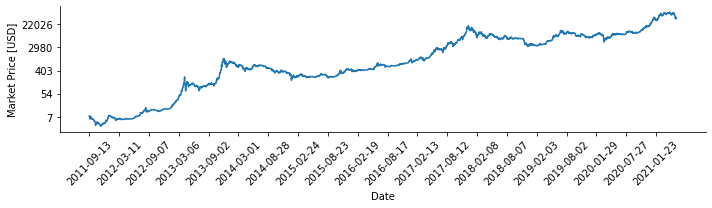

In [10]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_ = sns.lineplot(x="Date", y= "log_market_price", data=df_blockchain, ax=ax)
new_ticks = plot_.get_xticklabels()
freq = 180
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = df_blockchain.iloc[::freq]["Date"].values
ax.set_xticklabels(labels, rotation=45)
log_labels = np.exp(np.arange(0,12,2)).astype(int)
ax.set_yticklabels(log_labels)

ax.set_ylabel("Market Price [USD]")
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(FIGDIR, "market_price.pdf"))

## Seasonality

In [11]:
df_blockchain["Month"] = pd.to_datetime(df_blockchain["Date"]).dt.month.astype('category')
df_blockchain["Week"] = pd.to_datetime(df_blockchain["Date"]).dt.dayofweek.astype('category')
df_blockchain["Quarter"] = pd.to_datetime(df_blockchain["Date"]).dt.quarter.astype('category')
df_blockchain["Year"] = pd.to_datetime(df_blockchain["Date"]).dt.year.astype('category')
df_blockchain["log_market_price"] = np.log1p(df_blockchain["market-price"])


### Quarter

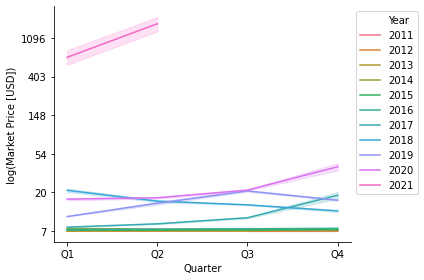

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))

plot = sns.lineplot(x="Quarter",
                    hue="Year",
                    y="market-price",
                    data=df_blockchain,
                    
                    ax=ax)

h, l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
plot.legend(h, l, bbox_to_anchor=(1, 1))

new_ticks = plot.get_xticklabels()
new_labels = ["Q1", "Q2", "Q3", "Q4"]
ax.set_xticks(np.arange(1, 5))
#labels = df_blockchain.iloc[::freq]["Date"].values
ax.set_xticklabels(new_labels)
ax.set_ylabel("log(Market Price [USD])")
log_labels = np.exp(np.arange(1, 10, 1)).astype(int)
ax.set_yticklabels(log_labels)
sns.despine()

plt.tight_layout()
fig.savefig(os.path.join(FIGDIR, "quarter_seasonplot.pdf"))

### Month

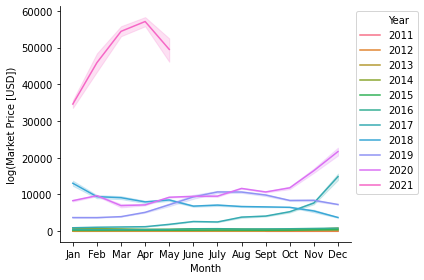

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))
plot = sns.lineplot(x="Month",
                    hue="Year",
                    y="market-price",
                    data=df_blockchain,
                    ax=ax)

h, l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
plot.legend(h, l, bbox_to_anchor=(1, 1))

new_ticks = plot.get_xticklabels()
new_labels = [
    "Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct",
    "Nov", "Dec"
]
ax.set_xticks(np.arange(1, 13))
#labels = df_blockchain.iloc[::freq]["Date"].values

ax.set_xticklabels(new_labels)
ax.set_ylabel("log(Market Price [USD])")
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(FIGDIR, "month_seasonplot.pdf"))

## Week

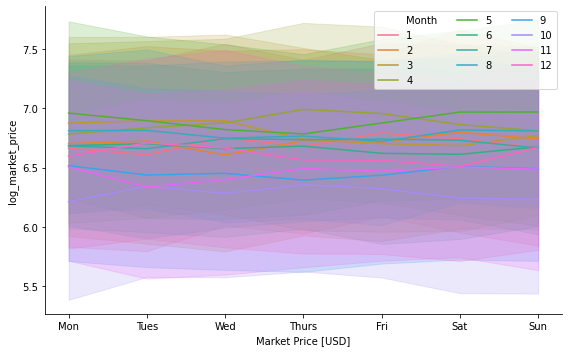

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))
plot = sns.lineplot(x="Week",
                    hue="Month",
                    y="log_market_price",
                    data=df_blockchain,
                    ax=ax)

h, l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
plot.legend(h, l, ncol=3)

new_ticks = plot.get_xticklabels()
new_labels = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
ax.set_xticks(np.arange(0, 7))

ax.set_xticklabels(new_labels)
ax.set_xlabel("Market Price [USD]")
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(FIGDIR, "week_seasonplot.pdf"))

In [34]:
market_price = df_blockchain["log_market_price"].values

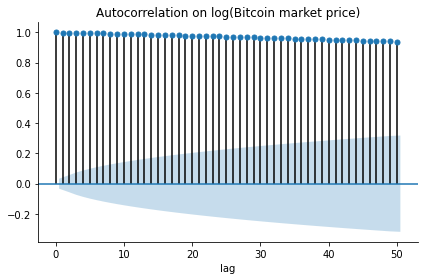

In [67]:
fig, ax = plt.subplots( figsize=(6,4))
plot_ = plot_acf(market_price, lags=50, ax=ax);
ax.set_title("Autocorrelation on log(Bitcoin market price)")
ax.set_xlabel("lag")
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(FIGDIR, "autocorrelation.pdf"))

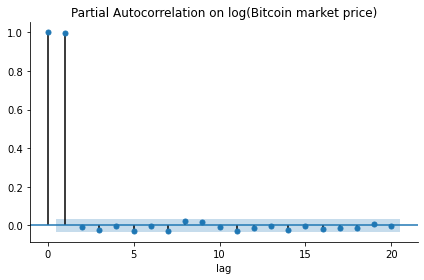

In [66]:
fig, ax = plt.subplots( figsize=(6,4))
plot_pacf(market_price, lags=20, ax=ax);
ax.set_title("Partial Autocorrelation on log(Bitcoin market price)")
ax.set_xlabel("lag")
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(FIGDIR, "partial_autocorrelation.pdf"))

# Augmented Dickey-Fuller test

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

Hypotheses:
- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

Interpretation:
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [37]:
result = adfuller(market_price)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.269083
p-value: 0.643196
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


__Conclusion:__
- Here we fail to reject the null hypothesis because p-value>0.5. It has some time dependent structure.

However as is ofthen observed with econometric data, the time series produced by the first-differences, ie y(t) = p(t)-p(t-1) is stationnary.


In [38]:
diff_market_price = market_price[1:]-market_price[:-1]

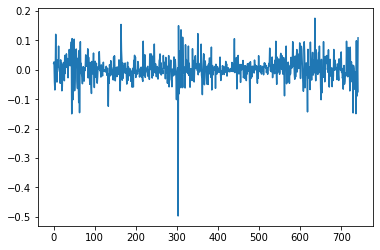

In [39]:
start = 2800
sns.lineplot(x =np.arange(len(diff_market_price[start:])), y= diff_market_price[start:] );

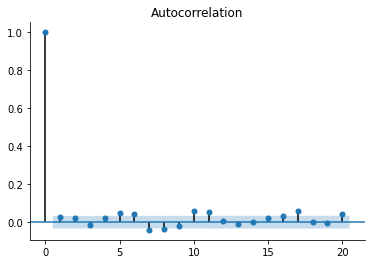

In [40]:
fig, ax = plt.subplots( figsize=(6,4))
plot_acf(diff_market_price, lags=20, ax=ax);
ax.set_title("Autocorrelation")
sns.despine()

In [42]:
result = adfuller(diff_market_price)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.326826
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


__Conclusions:__
- We reject the null hypothesis, first differences are stationnary.

# Modeling with ARIMA
AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.


Here, we already have d=1, p=5, q=5.

## First example

In [48]:
model = ARIMA(market_price, order=(5,2,5))
model_fit = model.fit(disp=0) # disp=0 to turn off debug verbose
print(model_fit.summary())

/Users/patricklee/Documents/04_formation/st4_mds_prepa/mds_env/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 3541
Model:                 ARIMA(5, 2, 5)   Log Likelihood                6062.745
Method:                       css-mle   S.D. of innovations              0.044
Date:                Wed, 26 May 2021   AIC                         -12101.489
Time:                        16:44:21   BIC                         -12027.423
Sample:                             2   HQIC                        -12075.072
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.328e-07   4.14e-06      0.201      0.841   -7.28e-06    8.95e-06
ar.L1.D2.y    -0.7224        nan        nan        nan         nan         nan
ar.L2.D2.y    -0.5644        nan        nan        n

/Users/patricklee/Documents/04_formation/st4_mds_prepa/mds_env/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/patricklee/Documents/04_formation/st4_mds_prepa/mds_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/patricklee/Documents/04_formation/st4_mds_prepa/mds_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/patricklee/Documents/04_formation/st4_mds_prepa/mds_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


# Debugging
line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.


                 0
count  3541.000000
mean      0.000415
std       0.043683
min      -0.494110
25%      -0.014358
50%       0.000422
75%       0.016554
max       0.312269


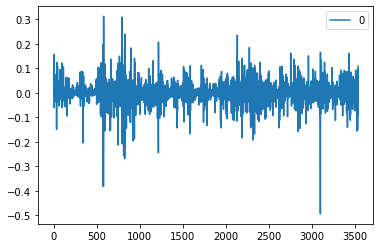

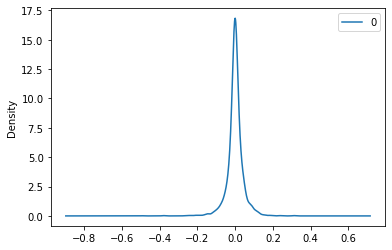

In [49]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')

print(residuals.describe())

## Methodology 
The classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology

1. Split the dataset into training and test sets.
2. Walk the time steps in the test dataset.
    1. Train an ARIMA model.
    2. Make a one-step prediction.
    3. Store prediction; get and store actual observation.
3. Calculate error score for predictions compared to expected values.

In [50]:
from sklearn.metrics import mean_squared_error
import warnings 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, test_set=30):
    # prepare training dataset
    
    train, test = X[:-test_set], X[-test_set::]
    history = [x for x in train]
    # make predictions
    predictions = list()
    
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat[0])
        history.append(test[t])
        
    # calculate out of sample error
    log_error = np.sqrt(mean_squared_error(test, predictions))
    error = np.sqrt(mean_squared_error(np.exp(test), np.exp(predictions)))
    
    return log_error, error, predictions

# evaluate combinations of p, d and q values for an ARIMA model
def grid_search(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                    
                except:
                    continue
                    
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [51]:
order=(0,1,1)
warnings.filterwarnings("ignore")
log_error, error, predictions = evaluate_arima_model(market_price, order)

In [52]:
print(error, log_error)

2982.485058716591 0.06416382881748078


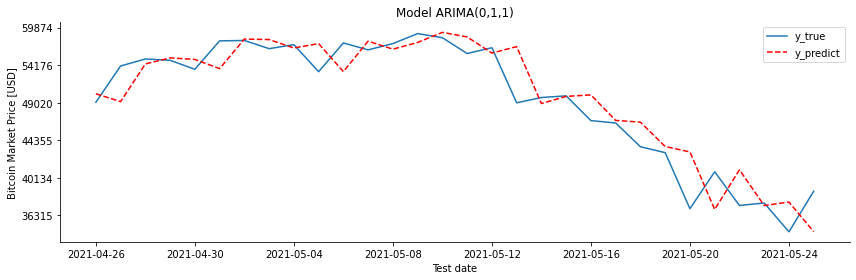

In [53]:
predict_date = df_blockchain.iloc[-30::]["Date"]
true_date = df_blockchain.iloc[-30::]["log_market_price"]
fig, ax = plt.subplots(figsize=(12,4))
df_predict = pd.DataFrame(zip(predict_date,
                              predictions, true_date),
                          columns=["date", "predict", "true"])
sns.lineplot(x="date", y="true", data=df_predict,ax=ax, label="y_true", markers=True )
plot_ = sns.lineplot(x="date",
             y="predict",
             data=df_predict,
             color="red",ax=ax, label="y_predict")
plot_.lines[1].set_linestyle("--")
new_ticks = plot_.get_xticklabels()
freq = 4
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = predict_date[::freq]
ax.set_xticklabels(labels)
log_labels = [np.exp(element.astype(float)).astype(int) for element in ax.get_yticks()]
ax.set_yticklabels(log_labels);
ax.set_ylabel("Bitcoin Market Price [USD]")
ax.set_xlabel("Test date")
ax.set_title("Model ARIMA(0,1,1)")
sns.despine()

plt.legend()
plt.tight_layout()
fig.savefig(os.path.join(FIGDIR, "predict.pdf"))

In [54]:
train_size = int(len(market_price) * 0.8)
train, test = market_price[0:train_size], market_price[train_size:]
    

diff_train_size = int(len(diff_market_price) * 0.8)
diff_train, diff_test = diff_market_price[0:diff_train_size], diff_market_price[diff_train_size:]

In [55]:
np.shape(test)

(709,)

In [56]:
res = np.array(predictions[:]).flatten()
np.shape(res)

(30,)

In [62]:
y_market_price = test.tolist() + res.tolist()

In [63]:
np.shape(predictions[0])

()

In [65]:
sns.lineplot(x=np.arange(len(res)), y=np.log1p(diff_test))
sns.lineplot(x=np.arange(len(res)), y=np.log1p(res), linestyle='dotted')

ValueError: arrays must all be same length

In [60]:
mean_squared_error(predictions, diff_test)

ValueError: Found input variables with inconsistent numbers of samples: [30, 709]

# GARCH

One aspect of a univariate time series that these autoregressive models (ARIMA, AR, SARIMA) do not model is a change in the variance over time.

Classically, a time series with modest changes in variance can sometimes be adjusted using a power transform, such as by taking the Log or using a Box-Cox transform.

There are some time series where the variance changes consistently over time. In the context of a time series in the financial domain, this would be called increasing and decreasing volatility.

In time series where the variance is increasing in a systematic way, such as an increasing trend, this property of the series is called heteroskedasticity. It’s a fancy word from statistics that means changing or unequal variance across the series.

Autoregressive Conditional Heteroskedasticity, or ARCH, is a method that explicitly models the change in variance over time in a time series.

q: The number of lag squared residual errors to include in the ARCH model.

The approach expects the series is stationary, other than the change in variance, meaning it does not have a trend or seasonal component. An ARCH model is used to predict the variance at future time steps.

Generalized Autoregressive Conditional Heteroskedasticity, or GARCH, is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component. The introduction of a moving average component allows the model to both model the conditional change in variance over time as well as changes in the time-dependent variance. Examples include conditional increases and decreases in variance.

- p: The number of lag variances to include in the GARCH model.
- q: The number of lag residual errors to include in the GARCH model.

# ARCH Model (to be finalised)
Developing an ARCH model involves three steps:

1. Define the model
2. Fit the model
3. Make a forecast.

Before fitting and forecasting, we can split the dataset into a train and test set so that we can fit the model on the train and evaluate its performance on the test set.

In [ ]:
! pip3 install pyflux
import pyflux as pf


def evaluate_arch(X, vol="GARCH", p=4, q=4):
    train_size = int(len(X) * 0.8)
    n_test = len((X))- train_size
    train, test = X[0:train_size], X[train_size:]
    model = pf.GARCH(train,p=p,q=q)
    #model = arch_model(train, mean='Zero', vol=vol, p=p, q=q)
    # fit model
    model_fit = model.fit()
    model_fit.summary()
    # forecast the test set
    model_fit.plot_predict(h=10)
    # calculate out of sample error
    #error = mean_squared_error(test, yhat.variance)
    return yhat

In [ ]:
yhat_arch = evaluate_arch(diff_market_price, vol="GARCH", p=4, q=4);